In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from estimators import *
from utils import *

In [ ]:
df_combined

RCT size: 1000, OS size: 7000, time elapsed: 24.37


,S,d,n,True mean Y0,Impute mean Y0,Drop mean Y0,Oracle-IPCW mean Y0,True mean Y1,Impute mean Y1,Drop mean Y1,Oracle-IPCW mean Y1,True ATE,Impute ATE,Drop ATE,Oracle-IPCW ATE
0,0,10,1000,2.276564,2.269009,2.269009,2.282717,9.514996,9.349856,9.314607,9.426477,7.238432,7.080847,7.045597,7.143760
1,1,10,7000,2.215283,2.029369,2.049582,2.118003,5.312526,4.212147,4.389335,4.953140,3.097244,2.182779,2.339753,2.835136


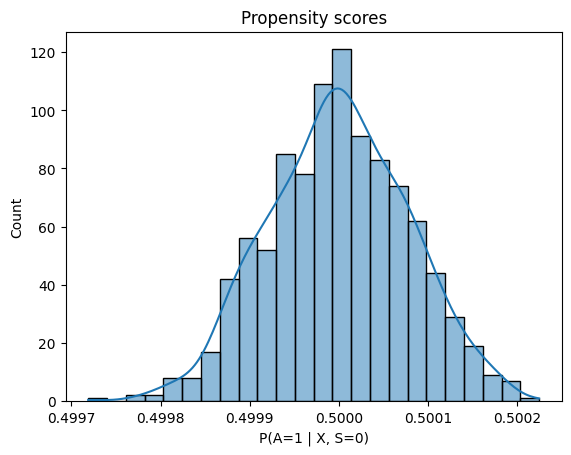

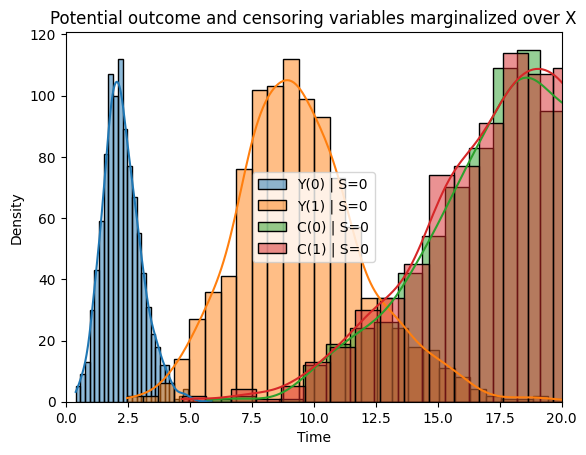

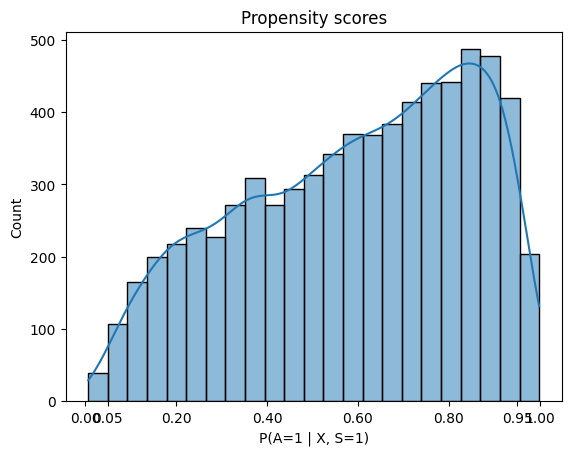

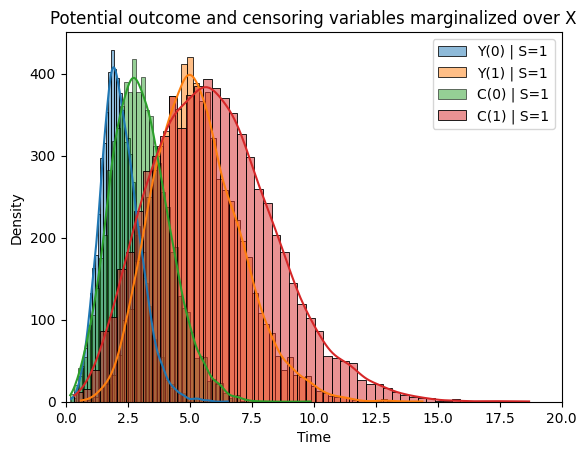

In [272]:
CD = 10
UC = 0
jD = read_json('complete-IC/diffPO.json', CD, UC, ["IPCW", "IPW-Drop", "IPW-Impute"])
m = 7
os_size = jD['rct_size'] * m

t1 = time()

df_combined, df_comb_drop, RCTData, OSData = generate_data(CD, os_size, jD)
fill_nuisance(df_combined, df_comb_drop, jD)

print('RCT size: {}, OS size: {}, time elapsed: {:.2f}'.format(jD['rct_size'], os_size, time() - t1))

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

In [ ]:
mmr_keys = ["IPCW", "IPW-Drop", "IPW-Impute"]
crop_prop = True

mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test

for kind, key in enumerate(mmr_keys):
    if 'Drop' in key:
        df_mmr = df_comb_drop.copy()
    else:
        df_mmr = df_combined.copy()

    if jD['crop_prop'] and ('Drop' not in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95) &\
                (0.01 < df_mmr['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

    if jD['crop_prop'] and ('Drop' in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95)].copy().reset_index(drop=True)

    signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
    mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(df_mmr, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)

In [ ]:
mmr_stats

In [271]:
len(df_comb_drop)

5592

In [5]:
df_combined

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,S0_ipcw_est_Y0,S1_ipcw_est_CATE,S1_ipcw_est_Y1,S1_ipcw_est_Y0,S0_impute_ipw_est_CATE,S0_impute_ipw_est_Y1,S0_impute_ipw_est_Y0,S1_impute_ipw_est_CATE,S1_impute_ipw_est_Y1,S1_impute_ipw_est_Y0
0,1.0,-1.622179,2.309169,1.555742,1.490984,0.247384,0.259482,0.061731,0.576357,-0.479628,...,34.344838,0.000000,0.000000,-0.000000,-34.344838,-0.000000,34.344838,0.000000,0.000000,-0.000000
1,1.0,0.236304,-0.632386,1.397240,1.596721,-0.235878,0.637412,1.218418,-0.194833,0.564443,...,-0.000000,0.000000,0.000000,-0.000000,11.008495,11.008495,-0.000000,0.000000,0.000000,-0.000000
2,1.0,-1.300962,-0.011004,1.234079,0.035258,0.474869,-0.484120,-0.558773,1.497405,1.198963,...,18.358112,0.000000,0.000000,-0.000000,-18.054720,-0.000000,18.054720,0.000000,0.000000,-0.000000
3,1.0,1.383953,0.566568,-0.385263,-0.147304,1.527358,0.464291,-0.380214,0.115900,-1.807696,...,-0.000000,0.000000,0.000000,-0.000000,43.712222,43.712222,-0.000000,0.000000,0.000000,-0.000000
4,1.0,0.668395,0.654916,0.878064,-0.964053,0.096072,-0.254456,-1.027309,0.959922,-0.067977,...,29.131437,0.000000,0.000000,-0.000000,-29.131437,-0.000000,29.131437,0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,1.474859,0.070933,1.149328,-0.212256,1.096560,1.795047,0.052754,-0.361388,0.868773,...,-0.000000,39.791174,39.791174,-0.000000,0.000000,0.000000,-0.000000,26.623064,26.623064,-0.000000
1996,1.0,-0.701457,-0.955307,1.266089,0.504775,-2.252551,0.827477,-1.098291,1.941970,-0.608015,...,-0.000000,1.808776,1.808776,-0.000000,0.000000,0.000000,-0.000000,1.735574,1.735574,-0.000000
1997,1.0,0.841791,0.504074,-0.371519,0.822822,0.291106,0.885153,-0.975399,0.062883,0.757008,...,-0.000000,-3.448911,-0.000000,3.448911,0.000000,0.000000,-0.000000,-3.360145,-0.000000,3.360145
1998,1.0,-0.960402,-0.033338,0.296510,-0.670341,-0.752946,-0.096424,0.881210,0.854953,-1.384136,...,-0.000000,11.925468,11.925468,-0.000000,0.000000,0.000000,-0.000000,9.994520,9.994520,-0.000000


In [ ]:
len(df_mmr)

In [54]:
df_mmr['P(S=1|X)'].sort_values()

263     0.455619
345     0.487791
486     0.522515
24      0.571011
27      0.579189
          ...   
1661    0.949922
3036    0.949956
587     0.949956
2312    0.949959
1911    0.949996
Name: P(S=1|X), Length: 4049, dtype: float64

In [188]:
# print('CDR-S0-ATE: {:.2f}\n'.format(df_mmr['S0_cdr_est_CATE'].mean()))
# print('CDR-S1-ATE: {:.2f}\n'.format(df_mmr['S1_cdr_est_CATE'].mean()))

print('IPCW-S0-Y0: {:.2f}'.format(df_mmr['S0_ipcw_est_Y0'].mean()))
print('IPCW-S0-Y1: {:.2f}'.format(df_mmr['S0_ipcw_est_Y1'].mean()))
print('IPCW-S0-ATE: {:.2f}\n'.format(df_mmr['S0_ipcw_est_CATE'].mean()))

print('IPCW-S1-Y0: {:.2f}'.format(df_mmr['S1_ipcw_est_Y0'].mean()))
print('IPCW-S1-Y1: {:.2f}'.format(df_mmr['S1_ipcw_est_Y1'].mean()))
print('IPCW-S1-ATE: {:.2f}\n'.format(df_mmr['S1_ipcw_est_CATE'].mean()))

print('IPW-Impute-S0-Y0: {:.2f}'.format(df_mmr['S0_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S0-Y1: {:.2f}'.format(df_mmr['S0_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S0-ATE: {:.2f}\n'.format(df_mmr['S0_impute_ipw_est_CATE'].mean()))

print('IPW-Impute-S1-Y0: {:.2f}'.format(df_mmr['S1_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S1-Y1: {:.2f}'.format(df_mmr['S1_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S1-ATE: {:.2f}\n'.format(df_mmr['S1_impute_ipw_est_CATE'].mean()))

print('IPW-Drop-S0-Y0: {:.2f}'.format(df_comb_drop['S0_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S0-Y1: {:.2f}'.format(df_comb_drop['S0_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S0-ATE: {:.2f}\n'.format(df_comb_drop['S0_drop_ipw_est_CATE'].mean()))

print('IPW-Drop-S1-Y0: {:.2f}'.format(df_comb_drop['S1_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S1-Y1: {:.2f}'.format(df_comb_drop['S1_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S1-ATE: {:.2f}'.format(df_comb_drop['S1_drop_ipw_est_CATE'].mean()))

summary_df

IPCW-S0-Y0: 1.82
IPCW-S0-Y1: 4.37
IPCW-S0-ATE: 2.55

IPCW-S1-Y0: 1.84
IPCW-S1-Y1: 3.77
IPCW-S1-ATE: 1.93

IPW-Impute-S0-Y0: 1.82
IPW-Impute-S0-Y1: 4.35
IPW-Impute-S0-ATE: 2.53

IPW-Impute-S1-Y0: 1.84
IPW-Impute-S1-Y1: 4.11
IPW-Impute-S1-ATE: 2.26

IPW-Drop-S0-Y0: 1.84
IPW-Drop-S0-Y1: 4.31
IPW-Drop-S0-ATE: 2.47

IPW-Drop-S1-Y0: 1.88
IPW-Drop-S1-Y1: 3.95
IPW-Drop-S1-ATE: 2.07


,S,d,n,True mean Y0,Impute mean Y0,Drop mean Y0,Oracle-IPCW mean Y0,True mean Y1,Impute mean Y1,Drop mean Y1,Oracle-IPCW mean Y1,True ATE,Impute ATE,Drop ATE,Oracle-IPCW ATE
0,0,6,1000,1.796507,1.803788,1.803788,1.833444,4.612311,4.525213,4.505646,4.472231,2.815804,2.721425,2.701858,2.638787
1,1,6,5000,1.865725,1.806996,1.806694,1.802746,4.349219,3.939428,3.899846,4.606610,2.483494,2.132433,2.093152,2.803864


In [ ]:
df_mmr


In [ ]:
df_mmr = df_combined
len(df_mmr)

In [ ]:
row = 1580

s = df_mmr.loc[row, 'S']
a = df_mmr.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_mmr.loc[row, 'T']
Delta = df_mmr.loc[row, 'Delta']

df_mmr.loc[row]

In [ ]:
eval_surv_(Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}'], T)

In [ ]:
eval_int_term_(s, a, x, T, Gb_C, Fb_Y)

In [ ]:
eval_Ystar_(s, a, x, Delta, T, Gb_C, Fb_Y)

In [ ]:
eval_Qfunc_(s, a, x, T, Fb_Y, thresh=1e-6)

In [ ]:
df_mmr['S1_ipcw_est_CATE'].sort_values()

In [ ]:
df_combined['T']

In [ ]:
top_5_indices = 

# Remove the rows with those indices from the DataFrame
df_filtered = df_combined.drop(df_combined['T'].nlargest(5).index)

In [ ]:
df_filtered['T'].max()

In [ ]:
df_combined['T'].max()

In [ ]:
df_mmr['S1_cdr_est_CATE'].sort_values()

In [ ]:
df_mmr['S1_ipcw_est_CATE'].sort_values()

In [ ]:
len(df_mmr)

In [ ]:
df_new['S0_cdr_est_CATE'].sort_values()

In [ ]:
df_new[['S1_cdr_est_CATE', 'S1_ipcw_est_CATE']].sort_values(by='S1_cdr_est_CATE')

In [ ]:
p_thr = 0.05

df_new = df_combined[(p_thr < df_combined['P(S=1|X)']) & (df_combined['P(S=1|X)'] < 1 - p_thr) &\
            (p_thr < df_combined['P(A=1|X,S)']) & (df_combined['P(A=1|X,S)'] < 1 - p_thr) &\
            (p_thr < df_combined['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

# df_new_drop = df_comb_drop[(p_thr < df_comb_drop['P(S=1|X)']) & (df_comb_drop['P(S=1|X)'] < 1 - p_thr) &\
#             (p_thr < df_comb_drop['P(A=1|X,S)']) & (df_comb_drop['P(A=1|X,S)'] < 1 - p_thr)].copy().reset_index(drop=True)

In [ ]:
len(df_new)

In [ ]:
df_combined.sort_values(by='P(S=1|X)')

In [ ]:
s, a = 1, 1
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

t1 = time()
func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
result, error = quad(func, 0, t_arr.max() + 10, limit=5)

print(f"Time: {time()-t1:.2f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max() + 10, 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
s, a = 0, 1
x = np.zeros(CD + 1)
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = ty #
st_arr = sty  


func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
t1 = time()
result, error = quad(func, 0, t_arr.max(), limit=1)
print(f"Time: {time()-t1:.5f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
Trange = np.linspace(0,8,51)
q_arr_normal = [eval_Qfunc_(s, a, x, T, Fb_Y) for T in Trange]
q_arr_batch = eval_Qfunc_arr_(s, a, x, Trange, Fb_Y)
plt.figure()
plt.plot(Trange, q_arr_normal, label='q_normal')
plt.plot(Trange, q_arr_batch, label='q_batch')
plt.legend()
plt.show()

In [ ]:
pv = np.load('results/complete-IC/samePO/CD-8/UC-0/pvals.npy')
csv = pd.read_csv('results/complete-IC/samePO/CD-8/UC-0/res_summary.csv')

In [ ]:
pv[0]

In [ ]:
np.mean(pv[0], axis=1)

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()